# Checkpoint #1

In [1]:
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/jamshedu/MLA-Final-Project/ANI-1_release/readers/lib/')
import pyanitools as pya

In [3]:
import pyanitools as pya

# Set the HDF5 file containing the data
hdf5file = 'ANI-1_release/ani_gdb_s01.h5'

# Construct the data loader class
data = pya.anidataloader(hdf5file)
data_iter = data.__iter__()
# Print the species of the data set one by one


In [4]:
mols = next(data_iter)
# Extract the data
P = mols['path']
X = mols['coordinates']
E = mols['energies']
S = mols['species']
sm = mols['smiles']

# Print the data
print("Path:   ", P)
print("  Smiles:      ","".join(sm))
print("  Symbols:     ", S)
print("  Coordinates: ", X.shape)
print("  Energies:    ", E.shape, "\n")

Path:    /gdb11_s01/gdb11_s01-0
  Smiles:       [H]C([H])([H])[H]
  Symbols:      ['C', 'H', 'H', 'H', 'H']
  Coordinates:  (5400, 5, 3)
  Energies:     (5400,) 



# Preliminary Information:

## Length of the coordinates is how many conformations there are for each molecule. This length is the same for final energies we need to predict. Ex. for water there are 1800 conformations and 1800 energies associated with them.

## Shape of the coordinates is rows x columns x array. Where each array is a coordinate value x, y, z. The rows correspond to each conformation and the columns correspond to each chemical species in the compound

## Working with the water molecule from s01 to show that the molecule can be read, train-test-split can be performed and batching occurs. Currently am calculating AEVs before conducting train-test-split, in the future may consider conducting train-test-split before calculating AEVs.

In [5]:
list_files_2 = ['ANI-1_release/ani_gdb_s01.h5']

data_set_X = []
y_energies = []

for i in list_files_2:
    hdf5file = i
    print(i)
    # Construct the data loader class
    data = pya.anidataloader(hdf5file)
    data_iter = data.__iter__()
    for mol in data_iter:  
        data_set_X.append({'species': mol['species'], 'coordinates': mol['coordinates']})
        y_energies.append(mol['energies'])

ANI-1_release/ani_gdb_s01.h5


In [6]:
data_set_X[0]

{'species': ['C', 'H', 'H', 'H', 'H'],
 'coordinates': array([[[-0.0034502 ,  0.01017081,  0.01938033],
         [-0.7954868 ,  0.5766599 , -0.5472012 ],
         [-0.39378393, -0.97992676,  0.2722862 ],
         [ 0.6344988 ,  0.4473651 ,  0.93568736],
         [ 0.59581804, -0.16517928, -0.8915708 ]],
 
        [[ 0.00311385, -0.02007288,  0.00282224],
         [-0.78331304,  0.7921426 , -0.26027855],
         [-0.45410746, -1.0295471 ,  0.31240797],
         [ 0.44713658,  0.63571125,  0.76770777],
         [ 0.7531731 , -0.1592813 , -0.85348135]],
 
        [[-0.0177954 , -0.02192003, -0.01129478],
         [-0.73020756,  0.6824338 , -0.30819252],
         [-0.382202  , -0.86773723,  0.3822439 ],
         [ 0.56933683,  0.50535196,  0.80417496],
         [ 0.75492465, -0.05902938, -0.74378157]],
 
        ...,
 
        [[ 0.00874467,  0.00214323, -0.00896647],
         [-0.85504687,  0.6273413 , -0.26081228],
         [-0.47105345, -0.9456285 ,  0.3252177 ],
         [ 0.48764503,

In [7]:
print(f'Length of final data set X is: {len(data_set_X)}')

Length of final data set X is: 3


## Symmetry Functions to calculate AEV for a particular atom in a molecule with a certain conformation

In [174]:
import numpy as np

def calc_f_C(Rij, RC):
    f_C_value = 0.5 * np.cos(np.pi * Rij / RC) + 0.5
    indicator = ((Rij <= RC) & (Rij != 0)).astype(float) # Make f_C(0)=0 to make sure the sum in distance conversion function and radial conversion function can run with j=i
    return f_C_value * indicator

def radial_component(Rijs, eta, Rs, RC=5.2):
    # Rijs is a 1d array, all other parameters are scalars
    f_C_values = calc_f_C(Rijs, RC)
    individual_components = np.exp(-eta * (Rijs - Rs) ** 2) * f_C_values
    return np.sum(individual_components)

def angular_component(Rij_vectors, Rik_vectors, zeta, theta_s, eta, Rs, RC=3.5):
    # Rij_vectors and Rik_vectors are 2d arrays with shape (n_atoms, 3), all other parameters are scalars
    # calculate theta_ijk values from vector operations
    dot_products = Rij_vectors.dot(Rik_vectors.T)
    Rij_norms = np.linalg.norm(Rij_vectors, axis=-1)
    Rik_norms = np.linalg.norm(Rik_vectors, axis=-1)
    norms = Rij_norms.reshape((-1, 1)).dot(Rik_norms.reshape((1, -1)))
    cos_values = np.clip(dot_products / (norms + 1e-8), -1, 1)
    theta_ijks = np.arccos(cos_values)
    theta_ijk_filter = (theta_ijks != 0).astype(float)
    mean_dists = (Rij_norms.reshape((-1, 1)) + Rik_norms.reshape((1, -1))) / 2
    f_C_values_Rij = calc_f_C(Rij_norms, RC)
    f_C_values_Rik = calc_f_C(Rik_norms, RC)
    f_C_values = f_C_values_Rij.reshape((-1, 1)).dot(f_C_values_Rik.reshape((1, -1)))
    individual_components = (1 + np.cos(theta_ijks - theta_s)) ** zeta * np.exp(-eta * (mean_dists - Rs) ** 2) * f_C_values * theta_ijk_filter
    return 2 ** (1 - zeta) * np.sum(individual_components)

def calc_aev(atom_types, coords, i_index):
    # atom_types are np.array of ints
    relative_coordinates = coords - coords[i_index]
    #print(f'Relative Coordinates: {relative_coordinates}')
    nearby_atom_indicator = np.linalg.norm(relative_coordinates, axis=-1) < 5.3
    #print(f'Nearby atoms: {nearby_atom_indicator}')
    relative_coordinates = relative_coordinates[nearby_atom_indicator]
    atom_types = atom_types[nearby_atom_indicator]
    radial_aev = np.array([radial_component(np.linalg.norm(relative_coordinates[atom_types == atom], axis=-1), eta, Rs) \
                           for atom in [0, 1, 2, 3] for eta in [16] \
                           for Rs in [0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000,\
                                   3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250]])
    angular_aev = np.array([angular_component(relative_coordinates[atom_types == atom_j], relative_coordinates[atom_types == atom_k],\
                                             zeta, theta_s, eta, Rs) \
                            for atom_j in [0, 1, 2, 3] for atom_k in range(atom_j, 4) for zeta in [32] \
                            for theta_s in [0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243]\
                            for eta in [8] for Rs in [0.900000,1.550000,2.200000,2.850000]])
    #print(len(radial_aev), len(angular_aev))
    return np.concatenate([radial_aev, angular_aev])

        

## Each AEV is 384 elements long and corresponds to 1 atom of a molecule in 1 conformation.
## So for s01, where there are 3 molecules, 
## CH4 (5400 conformations, 5 aevs/conformation), NH3 (3600 conformations, 4 aevs/conformation), H20 (1800, 3 aevs/conformation)
## total aevs = 27,000, 14,400, 5400
## For Water the shape we should use is (1800, 3, 384), 1800 conformations for (3 x 384)

In [175]:
water = data_set_X[2]
water_energies = y_energies[2]
water['coordinates'].shape

(1800, 3, 3)

## Function to convert coordinates to AEV for a molecule, with an output shape of (num_conformations, num_atoms, 384)

In [176]:
from functools import wraps
from time import time
from tqdm import tqdm

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [179]:
@timing
def convert_coordinates_to_aev(coordinates, species):
    mapping={"H":0, "C":1, "N":2, "O":3}
    elements = np.array([mapping[atom] for atom in species])
    print(elements)
    return_list = []
    for i in tqdm(range(len(coordinates)), leave=False):
        new_list = []
        for j in range(len(elements)):
            new_list.append(calc_aev(elements, coordinates[i], j))
        return_list.append(new_list)
    return np.array(return_list)

In [180]:
water_aevs = convert_coordinates_to_aev(water['coordinates'], water['species'])

[3 0 0]


func:'convert_coordinates_to_aev'  took: 208.5673 sec


In [183]:
water_aevs.shape

(1800, 3, 384)

In [184]:
water_atoms = data_set_X[2]['species']
water_atoms

['O', 'H', 'H']

# Train Test Validation Splits

## Splitting the water_aevs (1800, 3, 384) and water_energies(1800,) into training, testing and validation sets below. These sets will be passed into our Trainer class to be further split into batches.

In [185]:
# setting seed with random_state = 42
mol_x_train, mol_x_test, mol_y_train, mol_y_test = train_test_split(water_aevs, water_energies, test_size=1/3, random_state=42)

In [186]:
print(f'Input shape for molecule training: {mol_x_train.shape}')
print(f'Output shape for molecule training: {mol_y_train.shape}')
print(f'Input shape for molecule testing: {mol_x_test.shape}')
print(f'Output shape for molecule testing: {mol_y_test.shape}')

Input shape for molecule training: (1200, 3, 384)
Output shape for molecule training: (1200,)
Input shape for molecule testing: (600, 3, 384)
Output shape for molecule testing: (600,)


In [187]:
# setting seed with random_state = 42
mol_x_train, mol_x_val, mol_y_train, mol_y_val = train_test_split(mol_x_train, mol_y_train, test_size=1/3, random_state=42)

In [188]:
print(f'Input shape for molecule training: {mol_x_train.shape}')
print(f'Output shape for molecule training: {mol_y_train.shape}')
print(f'Input shape for molecule validation: {mol_x_val.shape}')
print(f'Output shape for molecule validation: {mol_y_val.shape}')

Input shape for molecule training: (800, 3, 384)
Output shape for molecule training: (800,)
Input shape for molecule validation: (400, 3, 384)
Output shape for molecule validation: (400,)


In [189]:
# Look into splitting the molecule before into train test split and then calculate aevs and then send it into the training

## Creating a Preliminary Model

In [190]:
class ANI(nn.Module):
    def __init__(self):
        super(ANI, self).__init__()
        self.sub_nets = nn.ModuleDict({"C": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,150),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.PReLU(),
                                                    nn.Linear(150, 50),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.PReLU(),
                                                    nn.Linear(50, 1)
                                                )), 
                                       "H": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,150),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.PReLU(),
                                                    nn.Linear(150, 50),
                                                    nn.PReLU(),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.Linear(50, 1)
                                                )),                                         
                                       "N": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,150),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.PReLU(),
                                                    nn.Linear(150, 50),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.PReLU(),
                                                    nn.Linear(50, 1)
                                                )), 
                                       "O": ANI_sub(nn.Sequential(
                                                    nn.Linear(384,150),
                                                    nn.PReLU(),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.Linear(150, 50),
                                                    nn.PReLU(),
                                                    #nn.LeakyReLU(0.1),
                                                    nn.Linear(50, 1)
                                                ))})

    ## We cannot use ReLU functions because there are negative values in our AEVs and backpropogation will fail because
    ## the derivative of ReLU will be 0.
    def forward(self, aevs, atom_types):
        
        num_conformations, num_atoms, aev_vector_length = list(aevs.size())
        '''
        print(num_conformations)
        print(num_atoms)
        print(aev_vector_length)
        '''
        new_shape_aevs = aevs.view(num_atoms, num_conformations, aev_vector_length)
        #print(f'New shape is: {new_shape_aevs.size()}')
       
        atomic_energies = torch.zeros(num_conformations, 1)
        #print(f'New shape is: {atomic_energies.size()}')
        for i in range(len(atom_types)):
            #print(self.sub_nets[atom_types[i]](new_shape_aevs[i]))
            #print(f'Return shape is: {self.sub_nets[atom_types[i]](new_shape_aevs[i]).size()}')
            atomic_energies += self.sub_nets[atom_types[i]](new_shape_aevs[i])
            #atomic_energies.cat()
        # convert atomic energies to tensor and then sum up values in each row (sum all the columns for a row) 
        # to get an 1800 x 1 vector.
        #print((atomic_energies).shape)
        
        #atomic_energies = np.array(holding_list).T
        
        #print(f'Complete atomic energies: {atomic_energies}')
        #print(f'Complete atomic energies: {atomic_energies[0].shape}')
        
        #atomic_energies = torch.tensor(atomic_energies[0], dtype=torch.float)
        
        # dim = 1 to sum on columns
        #total_energies = torch.sum(atomic_energies,dim=1)
        #print(atomic_energies)
        return atomic_energies.view(num_conformations)

class ANI_sub(nn.Module):
    def __init__(self, architecture):
        super(ANI_sub, self).__init__()
        self.layers = architecture

    def forward(self, aev):
        #aev = torch.tensor(aev, dtype=torch.float)
        atomic_energy = self.layers(aev)
        #print(atomic_energy)
        return atomic_energy


## Trainer Class that will convert Training and Validation sets of our data into batches for use in our model

In [191]:
from torch.optim import SGD, Adam
from torch import nn
import torch
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size

    @timing
    def train(self, atom_types, inputs, outputs, val_inputs, val_outputs, draw_curve=True, early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures) should be 32x32.
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        #...
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.float)
                
        losses = []
        val_losses = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        loss_func = nn.MSELoss()
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            #epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                # self.model(aevs, atom_types)
                
                #print(batch_input.shape)
        
                batch_predictions = self.model(batch_input, atom_types)
                
                #print(batch_predictions.shape)

                #MSELoss here.
                loss = loss_func(batch_predictions, batch_output) 
                
                #print(loss)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + 0.00001 * l2_norm
                    #lambda is 1e-5 == 0.00001
                    
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ### Compute epoch_loss 

                epoch_loss += loss.detach().cpu().item() * batch_importance

            #print(val_inputs.shape)
            val_loss = self.evaluate(atom_types, val_inputs, val_outputs)
            if n_epoch % 10 ==0 and not silent:
                print("Epoch %d/%d - Loss: %.3f" % (n_epoch + 1, self.epoch, epoch_loss))
                print("              Val_loss: %.3f" % (val_loss))
                print("              Batch_size: %.3f" % (self.batch_size))
            losses.append(epoch_loss)
            val_losses.append(val_loss)
            '''
            xd = 0
            for param in self.model.parameters():
                print(f'Parameter {xd}: {param}')
                xd+=1
            '''    
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(self.epoch) + 1,losses,label='Training loss')
            plt.plot(np.arange(self.epoch) + 1,val_losses,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(atom_types)
            plt.legend()
        
        if early_stop:
            self.model.load_state_dict(weights)    
        
        return {"losses": losses, "val_losses": val_losses}
        
    def evaluate(self, atom_types, inputs, outputs, print_loss=False):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.float)
        
        loss_func = nn.MSELoss()
        
        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        #print(f"batch indices length = {len(batch_indices)}")
        #print(f"output length = {len(outputs)}")
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                ### Compute prediction and loss###
                batch_predictions = self.model(batch_input, atom_types)
                #print(batch_predictions)
                #print(len(batch_input))
                #print(batch_importance)
                '''
                print(batch_predictions)
                print(batch_output)
                '''
                loss = loss_func(batch_predictions, batch_output)
                #print(loss)
                
            losses += loss.detach().cpu().item() * batch_importance
        if print_loss:
            print("Val Loss: %.3f" % losses, "Batch size: %.3f" % self.batch_size)
        return losses

In [192]:
ANI = ANI()

In [193]:
ANI_trainer = Trainer(ANI, "adam", 2e-3, 50, 128)

  6%|█████                                                                               | 3/50 [00:00<00:03, 11.97it/s]

Epoch 1/50 - Loss: 5724.198
              Val_loss: 5584.208
              Batch_size: 128.000


 26%|█████████████████████▌                                                             | 13/50 [00:01<00:03, 11.69it/s]

Epoch 11/50 - Loss: 13.034
              Val_loss: 19.403
              Batch_size: 128.000


 42%|██████████████████████████████████▊                                                | 21/50 [00:01<00:02, 12.19it/s]

Epoch 21/50 - Loss: 5.211
              Val_loss: 5.295
              Batch_size: 128.000


 66%|██████████████████████████████████████████████████████▊                            | 33/50 [00:02<00:01, 12.37it/s]

Epoch 31/50 - Loss: 1.950
              Val_loss: 2.078
              Batch_size: 128.000


 86%|███████████████████████████████████████████████████████████████████████▍           | 43/50 [00:03<00:00, 12.59it/s]

Epoch 41/50 - Loss: 0.898
              Val_loss: 0.923
              Batch_size: 128.000


func:'train'  took: 4.2310 sec


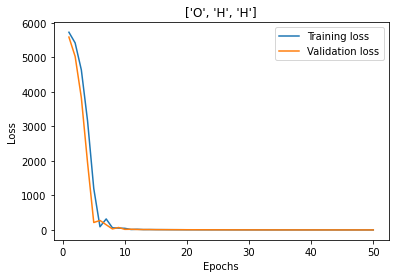

In [194]:
log=ANI_trainer.train(water_atoms, mol_x_train, mol_y_train, mol_x_val, mol_y_val)

In [195]:
log

{'losses': [5724.1984375,
  5415.91513671875,
  4633.692265625,
  3159.18169921875,
  1198.9079589843752,
  92.01892333984374,
  318.23597290039066,
  62.482176513671874,
  52.836027221679686,
  46.585035247802736,
  13.034221954345702,
  18.987271118164063,
  10.49529281616211,
  11.216952667236328,
  9.461788501739502,
  8.77649574279785,
  7.841174507141113,
  6.695714263916015,
  6.349991226196289,
  5.184127521514893,
  5.211398010253906,
  4.697943935394287,
  4.253400344848632,
  3.8514439773559572,
  3.8712657737731933,
  3.519387264251709,
  3.151278285980225,
  2.7454326343536377,
  2.4565050315856936,
  2.2281225013732913,
  1.9500830936431885,
  1.8141322708129883,
  1.6728304290771485,
  1.6086114835739136,
  1.3255649852752687,
  1.290616307258606,
  1.1694020986557008,
  1.0887154483795167,
  1.0235727405548094,
  1.0662174463272094,
  0.8983979177474976,
  0.7937268924713134,
  0.8224004697799684,
  0.743370475769043,
  0.6655102014541626,
  0.6454843330383301,
  0.6439

## The model is now working with the training and validation error not getting any lower for water. They are also not diverging so we are not over-fitting yet, however we could be under fitting. Now we will attempt to train on all the molecules in the s01 dataset (contains methane, ammonia, and water).

[1 0 0 0 0]


func:'convert_coordinates_to_aev'  took: 1160.7675 sec
['C', 'H', 'H', 'H', 'H']


  2%|█▋                                                                                  | 1/50 [00:00<00:19,  2.49it/s]

Epoch 1/50 - Loss: 907.332
              Val_loss: 21.533
              Batch_size: 128.000


 22%|██████████████████▎                                                                | 11/50 [00:04<00:15,  2.50it/s]

Epoch 11/50 - Loss: 0.629
              Val_loss: 0.628
              Batch_size: 128.000


 42%|██████████████████████████████████▊                                                | 21/50 [00:08<00:11,  2.55it/s]

Epoch 21/50 - Loss: 0.137
              Val_loss: 0.139
              Batch_size: 128.000


 62%|███████████████████████████████████████████████████▍                               | 31/50 [00:12<00:07,  2.52it/s]

Epoch 31/50 - Loss: 0.043
              Val_loss: 0.042
              Batch_size: 128.000


 82%|████████████████████████████████████████████████████████████████████               | 41/50 [00:16<00:03,  2.57it/s]

Epoch 41/50 - Loss: 0.021
              Val_loss: 0.021
              Batch_size: 128.000


func:'train'  took: 20.0270 sec
[2 0 0 0]


func:'convert_coordinates_to_aev'  took: 609.4597 sec
['N', 'H', 'H', 'H']


  2%|█▋                                                                                  | 1/50 [00:00<00:10,  4.77it/s]

Epoch 1/50 - Loss: 734.798
              Val_loss: 129.281
              Batch_size: 128.000


 22%|██████████████████▎                                                                | 11/50 [00:02<00:09,  4.26it/s]

Epoch 11/50 - Loss: 0.545
              Val_loss: 0.536
              Batch_size: 128.000


 42%|██████████████████████████████████▊                                                | 21/50 [00:04<00:07,  4.09it/s]

Epoch 21/50 - Loss: 0.207
              Val_loss: 0.216
              Batch_size: 128.000


 62%|███████████████████████████████████████████████████▍                               | 31/50 [00:07<00:04,  3.87it/s]

Epoch 31/50 - Loss: 0.124
              Val_loss: 0.123
              Batch_size: 128.000


 82%|████████████████████████████████████████████████████████████████████               | 41/50 [00:11<00:03,  2.43it/s]

Epoch 41/50 - Loss: 0.078
              Val_loss: 0.082
              Batch_size: 128.000


func:'train'  took: 15.0265 sec
[3 0 0]


func:'convert_coordinates_to_aev'  took: 235.9434 sec
['O', 'H', 'H']


  2%|█▋                                                                                  | 1/50 [00:00<00:05,  9.57it/s]

Epoch 1/50 - Loss: 3060.517
              Val_loss: 608.713
              Batch_size: 128.000


 24%|███████████████████▉                                                               | 12/50 [00:01<00:06,  6.01it/s]

Epoch 11/50 - Loss: 2.136
              Val_loss: 2.520
              Batch_size: 128.000


 44%|████████████████████████████████████▌                                              | 22/50 [00:03<00:05,  5.54it/s]

Epoch 21/50 - Loss: 0.462
              Val_loss: 0.474
              Batch_size: 128.000


 64%|█████████████████████████████████████████████████████                              | 32/50 [00:05<00:03,  4.96it/s]

Epoch 31/50 - Loss: 0.293
              Val_loss: 0.311
              Batch_size: 128.000


 84%|█████████████████████████████████████████████████████████████████████▋             | 42/50 [00:07<00:01,  6.31it/s]

Epoch 41/50 - Loss: 0.239
              Val_loss: 0.244
              Batch_size: 128.000


func:'train'  took: 8.7585 sec


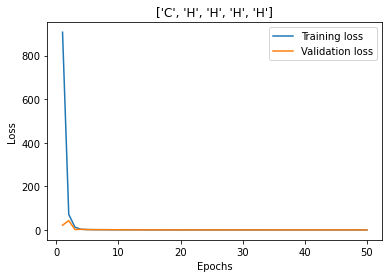

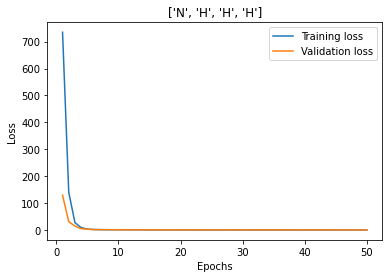

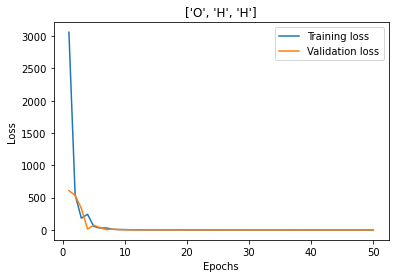

In [309]:
# The commented code below will get all the molecules for a h5 file in the ANI-1 dataset
'''
list_files_2 = ['ANI-1_release/ani_gdb_s01.h5']

data_set_X = []
y_energies = []

for i in list_files_2:
    hdf5file = i
    print(i)
    # Construct the data loader class
    data = pya.anidataloader(hdf5file)
    data_iter = data.__iter__()
    for mol in data_iter:  
        data_set_X.append({'species': mol['species'], 'coordinates': mol['coordinates']})
        y_energies.append(mol['energies'])
'''
# Intialize the model outside of the for loop which loops through the molecules in the data_set_X
ANI_1 = ANI()
ANI_trainer_1 = Trainer(ANI_1, "adam", 2e-3, 50, 128)

# Turn this into a function
for i in range(len(data_set_X)):
    mol = data_set_X[i]
    mol_energies = y_energies[i]
    mol_atoms = data_set_X[i]['species']

    mol_aevs = convert_coordinates_to_aev(mol['coordinates'], mol['species'])
    print(mol_atoms)

    mol_x_train, mol_x_test, mol_y_train, mol_y_test = train_test_split(mol_aevs, mol_energies, test_size=1/3, random_state=42)
    mol_x_train, mol_x_val, mol_y_train, mol_y_val = train_test_split(mol_x_train, mol_y_train, test_size=1/3, random_state=42)

    ANI_trainer_1.train(mol_atoms, mol_x_train, mol_y_train, mol_x_val, mol_y_val)    
    